## Imports

In [12]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.svm import SVC


## Setup

In [13]:
# set the random seed so that results are reproducible
np.random.seed(42)

# load all features and labels of the dataset
features, labels = np.load('./features.npy'), np.load('./labels.npy')

# remove the one broken data point
features, labels = np.delete(features, 102, 0), np.delete(labels, 102, 0)

# define lists for storing the discarded datapoints
discarded_features = []
discarded_labels = []

# define emtpy lists for final plotting
accuracy_svm = []
sensitivity_svm = []
accuracy_naivebayes = []
sensitivity_naviebayes = []
dataset_size = []

# calculations for how many data points have to be removed each time
count_classes = np.bincount(labels)
periphl_scale = count_classes[0]/len(features)
central_scale = count_classes[1]/len(features)
healthy_scale = count_classes[2]/len(features)
multiplier = 0.05*len(features)
end_size = 0.2*len(features)


## Definitions

In [14]:
def dataset_cutter(features, labels, discarded_features, discarded_labels):
    """this funcion removes some entries for each class from the dataset, and adds these to a different array"""
    count_classes = np.bincount(labels)
    for i in range (int(round(periphl_scale*multiplier))): # remove some peripheral,
        np.random.shuffle(features[0:count_classes[0]])
        index = 0
        discarded_features.append(features[index])
        discarded_labels.append(labels[index])
        features = np.delete(features, index, 0)
        labels = np.delete(labels, index, 0)
    for i in range (int(round(central_scale*multiplier))): # some central,
        np.random.shuffle(features[count_classes[0]:(count_classes[0] + count_classes[1])])
        index = 0+count_classes[0]
        discarded_features.append(features[index])
        discarded_labels.append(labels[index])
        features = np.delete(features, index, 0)
        labels = np.delete(labels, index, 0)
    for i in range (int(round(healthy_scale*multiplier))): # and some healthy datapoints
        np.random.shuffle(features[(count_classes[0] + count_classes[1]):((count_classes[0] + count_classes[1] + count_classes[2]))])
        index = 0+count_classes[0]+count_classes[1]
        discarded_features.append(features[index])
        discarded_labels.append(labels[index])
        features = np.delete(features, index, 0)
        labels = np.delete(labels, index, 0)
    # discarded_features = np.reshape(discarded_features, (len(discarded_features),-1))
    # discarded_labels = np.reshape(discarded_labels, (len(discarded_labels)))
    return features, labels, discarded_features, discarded_labels


## Calculations

In [16]:
# test accuracy and sensitivity untill the dataset is too small for functional testing
while len(features) > end_size:
    # print("Remaining number of each class [peripheral central healthy] in the training dataset:",np.bincount(labels))

    # calculate LOOCV accuracy for svm
    correct = 0
    n1 = len(features)
    for i in range(n1):
        x_test = features[i]
        x_test = np.reshape(x_test, ([1,-1]))
        y_test = labels[i]
        x_train_loocv = np.delete(features, i, 0)
        y_train_loocv = np.delete(labels, i, 0)
        modelsvm = SVC(kernel='poly',degree=5,class_weight='balanced')
        modelsvm.fit(x_train_loocv, y_train_loocv)
        prediction = modelsvm.predict(x_test)
        if (prediction == y_test):
            correct += 1
    accuracy1 = correct/n1

    n2 = len(discarded_features)
    accuracy2 = 0
    if n2 > 0:
        modelsvm = SVC(kernel='poly',degree=5,class_weight='balanced')
        modelsvm.fit(features, labels)
        accuracy2 = modelsvm.score(discarded_features, discarded_labels)

    accuracy = n1/(n1+n2)*accuracy1 + n2/(n1+n2)*accuracy2

    # print("accuracy1 =", accuracy1, "accuracy2=", accuracy2)

    # store accuracy...
    accuracy_svm.append(accuracy)

    # ...and dataset size
    dataset_size.append(len(features))

    if type(discarded_features) is not list:
        discarded_features = discarded_features.tolist()
    features, labels, discarded_features, discarded_labels = dataset_cutter(features, labels, discarded_features, discarded_labels)

## Plots

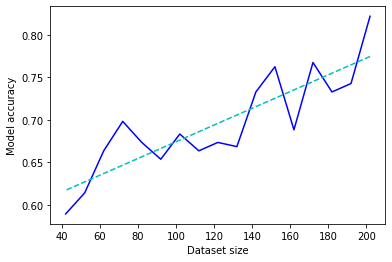

In [17]:
# calculate the polynomial of best fit of degree deg
m, b = np.polyfit(dataset_size, accuracy_svm, deg=1)

# plot accuracy to dataset size and also the line of best fit
plt.plot(dataset_size, accuracy_svm, ls='solid', c='b')
dataset_size = np.asarray(dataset_size)
plt.plot(dataset_size, m*dataset_size+b, ls='dashed', c='c')
plt.ylabel('Model accuracy')
plt.xlabel('Dataset size')
plt.show()